In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmasher as cmr
import cartopy.crs as ccrs
from tools import set_hatch_color

import geopandas as gpd
import cartopy.feature as cfeature
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union

In [7]:
imerg = xr.open_dataset("../data/external/gpm_merra2/NASA_GPM_L3_IMERG_V06_2024.nc").precipitationCal
imergp = xr.open_dataset("../data/external/gpm_merra2/percentiles_NASA_GPM_L3_IMERG_V06_apr_may.nc").precipitationCal

merra = xr.open_dataset("../data/external/gpm_merra2/NASA_GSFC_MERRA_slv_2_2024.nc")
merrap = xr.open_dataset("../data/external/gpm_merra2/percentiles_NASA_GSFC_MERRA_slv_2_apr_may.nc")

In [8]:
merra["SPD10M"] = np.sqrt(merra["U10M"]**2 + merra["V10M"]**2)

merra["U10Mn"] = merra["U10M"]/merra["SPD10M"]
merra["V10Mn"] = merra["V10M"]/merra["SPD10M"]

tslice = slice("2024-04-26", "2024-05-07")

merram = merra.sel(time=tslice).mean("time")
imergm = imerg.sel(time=tslice).mean("time")

dT10M = (merram.T10M-merrap.T10M)
dTQV = (merram.TQV-merrap.TQV)
dRain = (imergm-imergp)

In [9]:
lons = imerg.lon.quantile([0,1]).values
lats = imerg.lat.quantile([0,1]).values

# Define a bounding box encompassing the entire American continent
bbox = Polygon([
    (lons[0], lats[0]),
    (lons[1], lats[0]),
    (lons[1], lats[1]),
    (lons[0], lats[1])
])

# Get the COASTLINE feature (high resolution recommended)
coastline = cfeature.COASTLINE.with_scale("10m")

# Filter coastlines within the American continent bounding box
selected_coastlines = []
for geometry in coastline.geometries():
    if bbox.intersects(geometry):
        selected_coastlines.append(geometry)

selected_coastlines = unary_union(selected_coastlines)


gdf = gpd.read_file("../data/external/shapefiles/RS_Municipios_2022")

rs_shape = gdf.geometry.unary_union

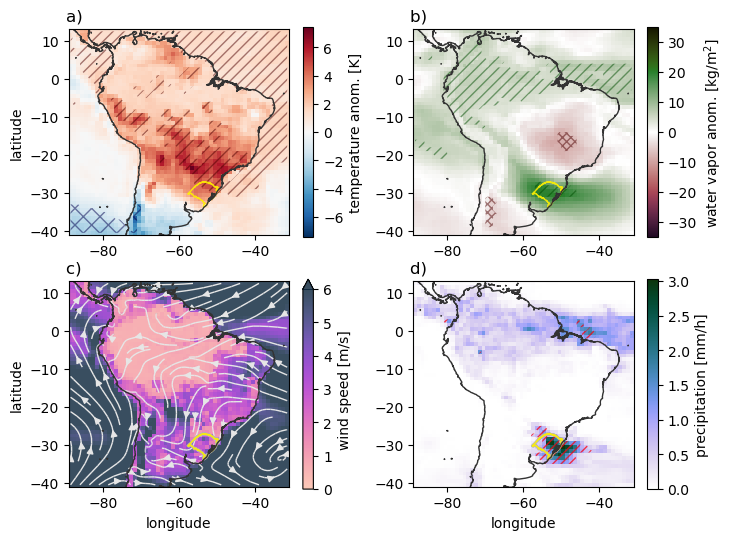

In [54]:
kw = {
    "hatch": {
        "levels": [0.5, 1.5],
        "extend": "neither",
        "colors": "none",
        "add_colorbar": False,
    }
}

fig, ax = plt.subplots(2, 2, figsize=(8, 6))
fig.subplots_adjust(wspace=0.25)
ax = np.hstack(ax)

dT10M.sel(percentile=50).plot(ax=ax[0], cbar_kwargs=dict(ticks=np.arange(-6,8,2), label="temperature anom. [K]"))
cs = (dT10M.sel(percentile=20)<0).plot.contourf(ax=ax[0], hatches=["xx"], **kw["hatch"])
set_hatch_color(cs, (0,0,0.3,0.5))
cs = (dT10M.sel(percentile=80)>0).plot.contourf(ax=ax[0], hatches=["///"], **kw["hatch"])
set_hatch_color(cs, (0.3,0,0,0.5))

dTQV.sel(percentile=50).plot(ax=ax[1], cmap="cmr.holly_r", vmin=-35, vmax=35, cbar_kwargs=dict(label="water vapor anom. [kg/m$^2$]"))
cs = (dTQV.sel(percentile=20)<0).plot.contourf(ax=ax[1], hatches=["xxxx"], **kw["hatch"])
set_hatch_color(cs, (0.3,0,0,0.5))
cs = (dTQV.sel(percentile=90)>0).plot.contourf(ax=ax[1], hatches=["///"], **kw["hatch"])
set_hatch_color(cs, (0,0.3,0,0.5))

merram.SPD10M.plot(ax=ax[2],vmin=0, vmax=6, cmap="cmr.bubblegum_r", alpha=0.8,
                   cbar_kwargs=dict(label="wind speed [m/s]"))
merram.plot.streamplot(
    ax=ax[2],
    x="lon", y="lat",
    u="U10Mn", v="V10Mn",
    density=0.8, linewidth=1,
    color="0.9"
)

imergm.plot(ax=ax[3], x="lon", y="lat", cmap="cmr.horizon_r", cbar_kwargs=dict(label="precipitation [mm/h]"))
cs = (dRain.sel(percentile=90)>0.5).plot.contourf(ax=ax[3], hatches=["////"], **kw["hatch"])
set_hatch_color(cs, "#ff000dbf")

[a.set(xlabel="", ylabel="", title=f"{lb})"+40*" ") for a, lb in zip(ax,"a b c d".split())]
[a.axis("scaled") for a in ax];
for i, a in enumerate(ax):
    for polygon in rs_shape.geoms:
        x, y = np.vstack(polygon.exterior.coords).T
        if i >= 2:
            a.plot(x, y, color="0.7", lw=2, alpha=0.9)
        a.plot(x, y, color="#fff000ff", lw=1, alpha=0.9)
    for line in selected_coastlines.geoms:
        x, y = line.xy
        a.plot(x, y, color="0.2", lw=1)
        
[a.set(xlabel="longitude") for a in ax[2:]];
[a.set(ylabel="latitude") for a in ax[::2]];

fig.savefig("../img/large_scale.png", dpi=300, facecolor="w", bbox_inches="tight")
